In [1]:
! apt install tesseract-ocr
! apt install libtesseract-dev
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libtesseract-dev is already the newest version (4.00~git2288-10f4998a-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#import packages
import pytesseract
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import re
import os
import shutil
from google.colab import drive
import datetime


In [3]:
#this will connect to your Google Drive. It will ask you to allow access
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [27]:
# create a file list data frame to keep the old-name -> new-name conversions and status 
file_names_list = []

In [29]:
# unzip folder if in zip mode
def unzip_src(folder):
  """
  Unzip zipped folder.

  A zipped folder is taken in and unzipped.

  Parameter
  ---------
  kind : Google Drive Folder
    Folder containing watershed photos.

  Returns
  -------
  new_src : new src for unzipped folder.
  unzipped : unzipped folder.

  """
  new_src = folder
  unzipped = None

  if folder[-4:] == '.zip':
    src_as_zip = True
    unzipped = folder[:-4]
    shutil.unpack_archive(folder, unzipped)

    parentZip = np.array(os.listdir(unzipped))
    new_src = unzipped + '/' + parentZip[0]
  
  return new_src, unzipped


def new_folder(src, dst = None):
  '''
  Create a new folder destination address for folder to be copied.

  This method's parameter is the address of folder you're going to copy, address of destination parent folder
  It will return the name of folder (to use later), full new address of copy folder 
  determines new folder address.

  Parameters
  ----------
  src : src address for folder to be copied.
  dst : destination address for folder to be copied.

  Returns
  -------
  folder_name : the new folders name.
  newAddress : the full new address of copy folder.
  '''
  if dst is None:
    dst = src
  # print(src, "Src")
  src_elements = src.split('/')
  folder_name = src_elements[-1][:2]
  # print(folder_name, "Folder")
  newAddress = dst + "/" + folder_name
  return folder_name, newAddress


def generate_picName(fdr_name, tStamp):
  '''
  Generate standardized picture names.

  The full source address of a pciture file and its time stamp are standardized 
  to a format delineated by water shed number and time stamp. 

  Parameters
  ----------
  fdr_name : full source address of current picture file.
  tStamp : unaltered timeStamp from bottom of the photo
      as a string.

  Returns
  -------
  new_name : new name of picture
  '''
  ws_num = fdr_name[1] #!!!this should be changed if src_elements[-2][1] will not be watershed number!!

  stamp_elements = re.split('[\n: -]', tStamp)
  date = stamp_elements[2] + stamp_elements[0] + stamp_elements[1]
  time = stamp_elements[3] + stamp_elements[4] + stamp_elements[5]

  new_name = "Hbwtr_w" + ws_num + '_' + date + '_' + time + '.JPG'
  return new_name

def extract_timeStamp(pic_address):
    '''
    Extract time Stamp from picture file.

    From the bottom right of each picture file, the time stamp is read as image using cv2. It is then converted to a string.
    text which is then checked for format and subsequently returned through match_date_format.

    Parameters
    ----------
    pic_address : full source address of current picture file.
    Returns
    -------
    match_date_format.group(0) : unaltered timeStamp from bottom of the photo as a string.
    '''
    # print(pic_address)
    img = cv2.imread(pic_address) #read as an image
    ts = img[2352:, 2000:, :] #(change if sizing conventions change!)
    text = pytesseract.image_to_string(ts)
    # print(text)
    # check if the timestamp is the correct format
    date_pattern = "\d\d-\d\d-\d\d\d\d \d\d:\d\d:\d\d" # eg 12-12-2020 11:59:32
    match_date_format = re.search(date_pattern,text)
    if not match_date_format:
      print("Correct timestamp not found")
    else:
      return match_date_format.group(0)

def rename_images(picFolder, fdr_name, fdr_dst):

  '''
  Rename all files in the current folder and populate the list of old and new names.

  For each picture file in the current folder, its filename is changed and its new name is generated in another method.
  The old image is copied to its new destination.

  Parameters
  ----------
  picFolder : a folder containing pictures.
  fdr_name : full address of folder.
  fdr_dst : full destination address.
  '''

  picFiles = np.array(os.listdir(picFolder))
  # print(picFiles, len(picFiles))


  for filename in picFiles:
    old_name = filename
    new_name = np.nan
    status="raw"
    note = np.nan
    print("Old filename", filename) #just to track where you are
    src = picFolder + '/' + filename #old img address
    # print(src)
    filetype = filename[-4:]
    try:
      if (filetype == '.JPG') or (filetype == '.jpg'):
        tStamp = extract_timeStamp(src)
        new_name = generate_picName(fdr_name, tStamp)
        print("New filename", new_name)
        status = "renamed"
        dst = fdr_dst + '/' + filename #new img address
        dst_renamed = fdr_dst + '/' + new_name #img new address + name
        shutil.copy(src, dst_renamed) #copies old image to new destination
        # os.rename(src, dst) #renames file in Google Drive
      else:
        print("Not image file")
        status= "error"
        note = "Not image file"
    except:
      print("Unable to process file")
      status = "error"
      note =  "Unable to process file"

    curr_list = [old_name, new_name, status, note]
    file_names_list.append(curr_list)



In [30]:
# MAIN

from glob import glob

#collect all folder paths from newly uploaded data on folder
folder_list = glob("/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/Newly_uploaded_data/*/", recursive = True)
# collect all folder path from on deck folder
folder_list.extend(glob("/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/On_Deck/*/", recursive = True))

# extract folder_name 
folder_list = [f[:-1] for f in folder_list]

# for each folder rename and add them to the new destination - dst
for folder in folder_list:
  dst = "/content/drive/MyDrive/2_Camera Trap photos/COPY of data for script/Testing destination"
  save_as_zip = False

  #will unzip if necessary
  folder, unzipped = unzip_src(folder)

  # #create new destination folder
  fdr_name, fdr_dst = new_folder(folder, dst)

  if os.path.exists(fdr_dst):
    print("path already exists")
  else:
    print("new path")
    os.mkdir(fdr_dst)

  rename_images(folder, fdr_name, fdr_dst)

new path
[] 0
new path
['desktop.ini'] 1
Old filename desktop.ini
Not image file
path already exists
['05100001.JPG' '05110003.JPG' '05120005.JPG' '05130008.JPG'
 '05140011.JPG' '05150013.JPG' '05160015.JPG' '05170018.JPG'
 '05180020.JPG' '05190023.JPG' '05200024.JPG' '05210026.JPG'
 '05220029.JPG' '05230031.JPG' '05240032.JPG' '05250034.JPG'
 '05260036.JPG' '05270038.JPG' '05280040.JPG' '05290042.JPG'
 '05300044.JPG' '05310046.JPG' '06010048.JPG' '06020050.JPG'
 '06030052.JPG' '06040054.JPG' '06050056.JPG' '06060058.JPG'
 '06070062.JPG' '06080063.JPG' '06090065.JPG' '06100067.JPG'
 '06110069.JPG' '06120071.JPG' '06130073.JPG' '06140075.JPG'
 '06150077.JPG' '06160079.JPG' '06170081.JPG' '06180083.JPG'
 '06190086.JPG' '06200087.JPG' '06210092.JPG' '06220093.JPG'
 '06230095.JPG' '06240098.JPG' '06250100.JPG' '06260102.JPG'
 '06270105.JPG' '06280106.JPG' '06290108.JPG' '06300111.JPG'
 '07010112.JPG' '07020114.JPG' '07030116.JPG' '07040119.JPG'
 '07050120.JPG' '07060122.JPG' '07070124.JPG'

In [32]:
# file_list data frame
file_df = pd.DataFrame(file_names_list, columns = ["old_name", "new_name", "status", "note"])
file_df

,old_name,new_name,status,note
0,desktop.ini,NaN,error,Not image file
1,05100001.JPG,Hbwtr_w3_20210510_115949.JPG,renamed,NaN
2,05110003.JPG,Hbwtr_w3_20210511_115948.JPG,renamed,NaN
3,05120005.JPG,Hbwtr_w3_20210512_115948.JPG,renamed,NaN
4,05130008.JPG,Hbwtr_w3_20210513_115947.JPG,renamed,NaN
...,...,...,...,...
162,10180344.JPG,Hbwtr_w3_20211018_115821.JPG,renamed,NaN
163,10190346.JPG,Hbwtr_w3_20211019_121518.JPG,renamed,NaN
164,10240348.JPG,Hbwtr_w3_20211024_115812.JPG,renamed,NaN
165,10250350.JPG,NaN,error,Unable to process file


In [34]:
# files with error status
file_df[file_df.status=="error"]

,old_name,new_name,status,note
0,desktop.ini,NaN,error,Not image file
165,10250350.JPG,NaN,error,Unable to process file
166,desktop.ini,NaN,error,Not image file


In [14]:
# files unable to process
file_df[file_df.note=="Unable to process file"]

,old_name,new_name,status,note
164,10250350.JPG,NaN,error,Unable to process file
172,05150013.JPG,Hbwtr_w3_20210515_115946.JPG,error,Unable to process file
173,05160015.JPG,Hbwtr_w3_20210516_115946.JPG,error,Unable to process file
174,05170018.JPG,Hbwtr_w3_20210517_115945.JPG,error,Unable to process file
175,05180020.JPG,Hbwtr_w3_20210518_115945.JPG,error,Unable to process file
...,...,...,...,...
327,10170342.JPG,Hbwtr_w3_20211017_115822.JPG,error,Unable to process file
328,10180344.JPG,Hbwtr_w3_20211018_115821.JPG,error,Unable to process file
329,10190346.JPG,Hbwtr_w3_20211019_121518.JPG,error,Unable to process file
330,10240348.JPG,Hbwtr_w3_20211024_115812.JPG,error,Unable to process file


True


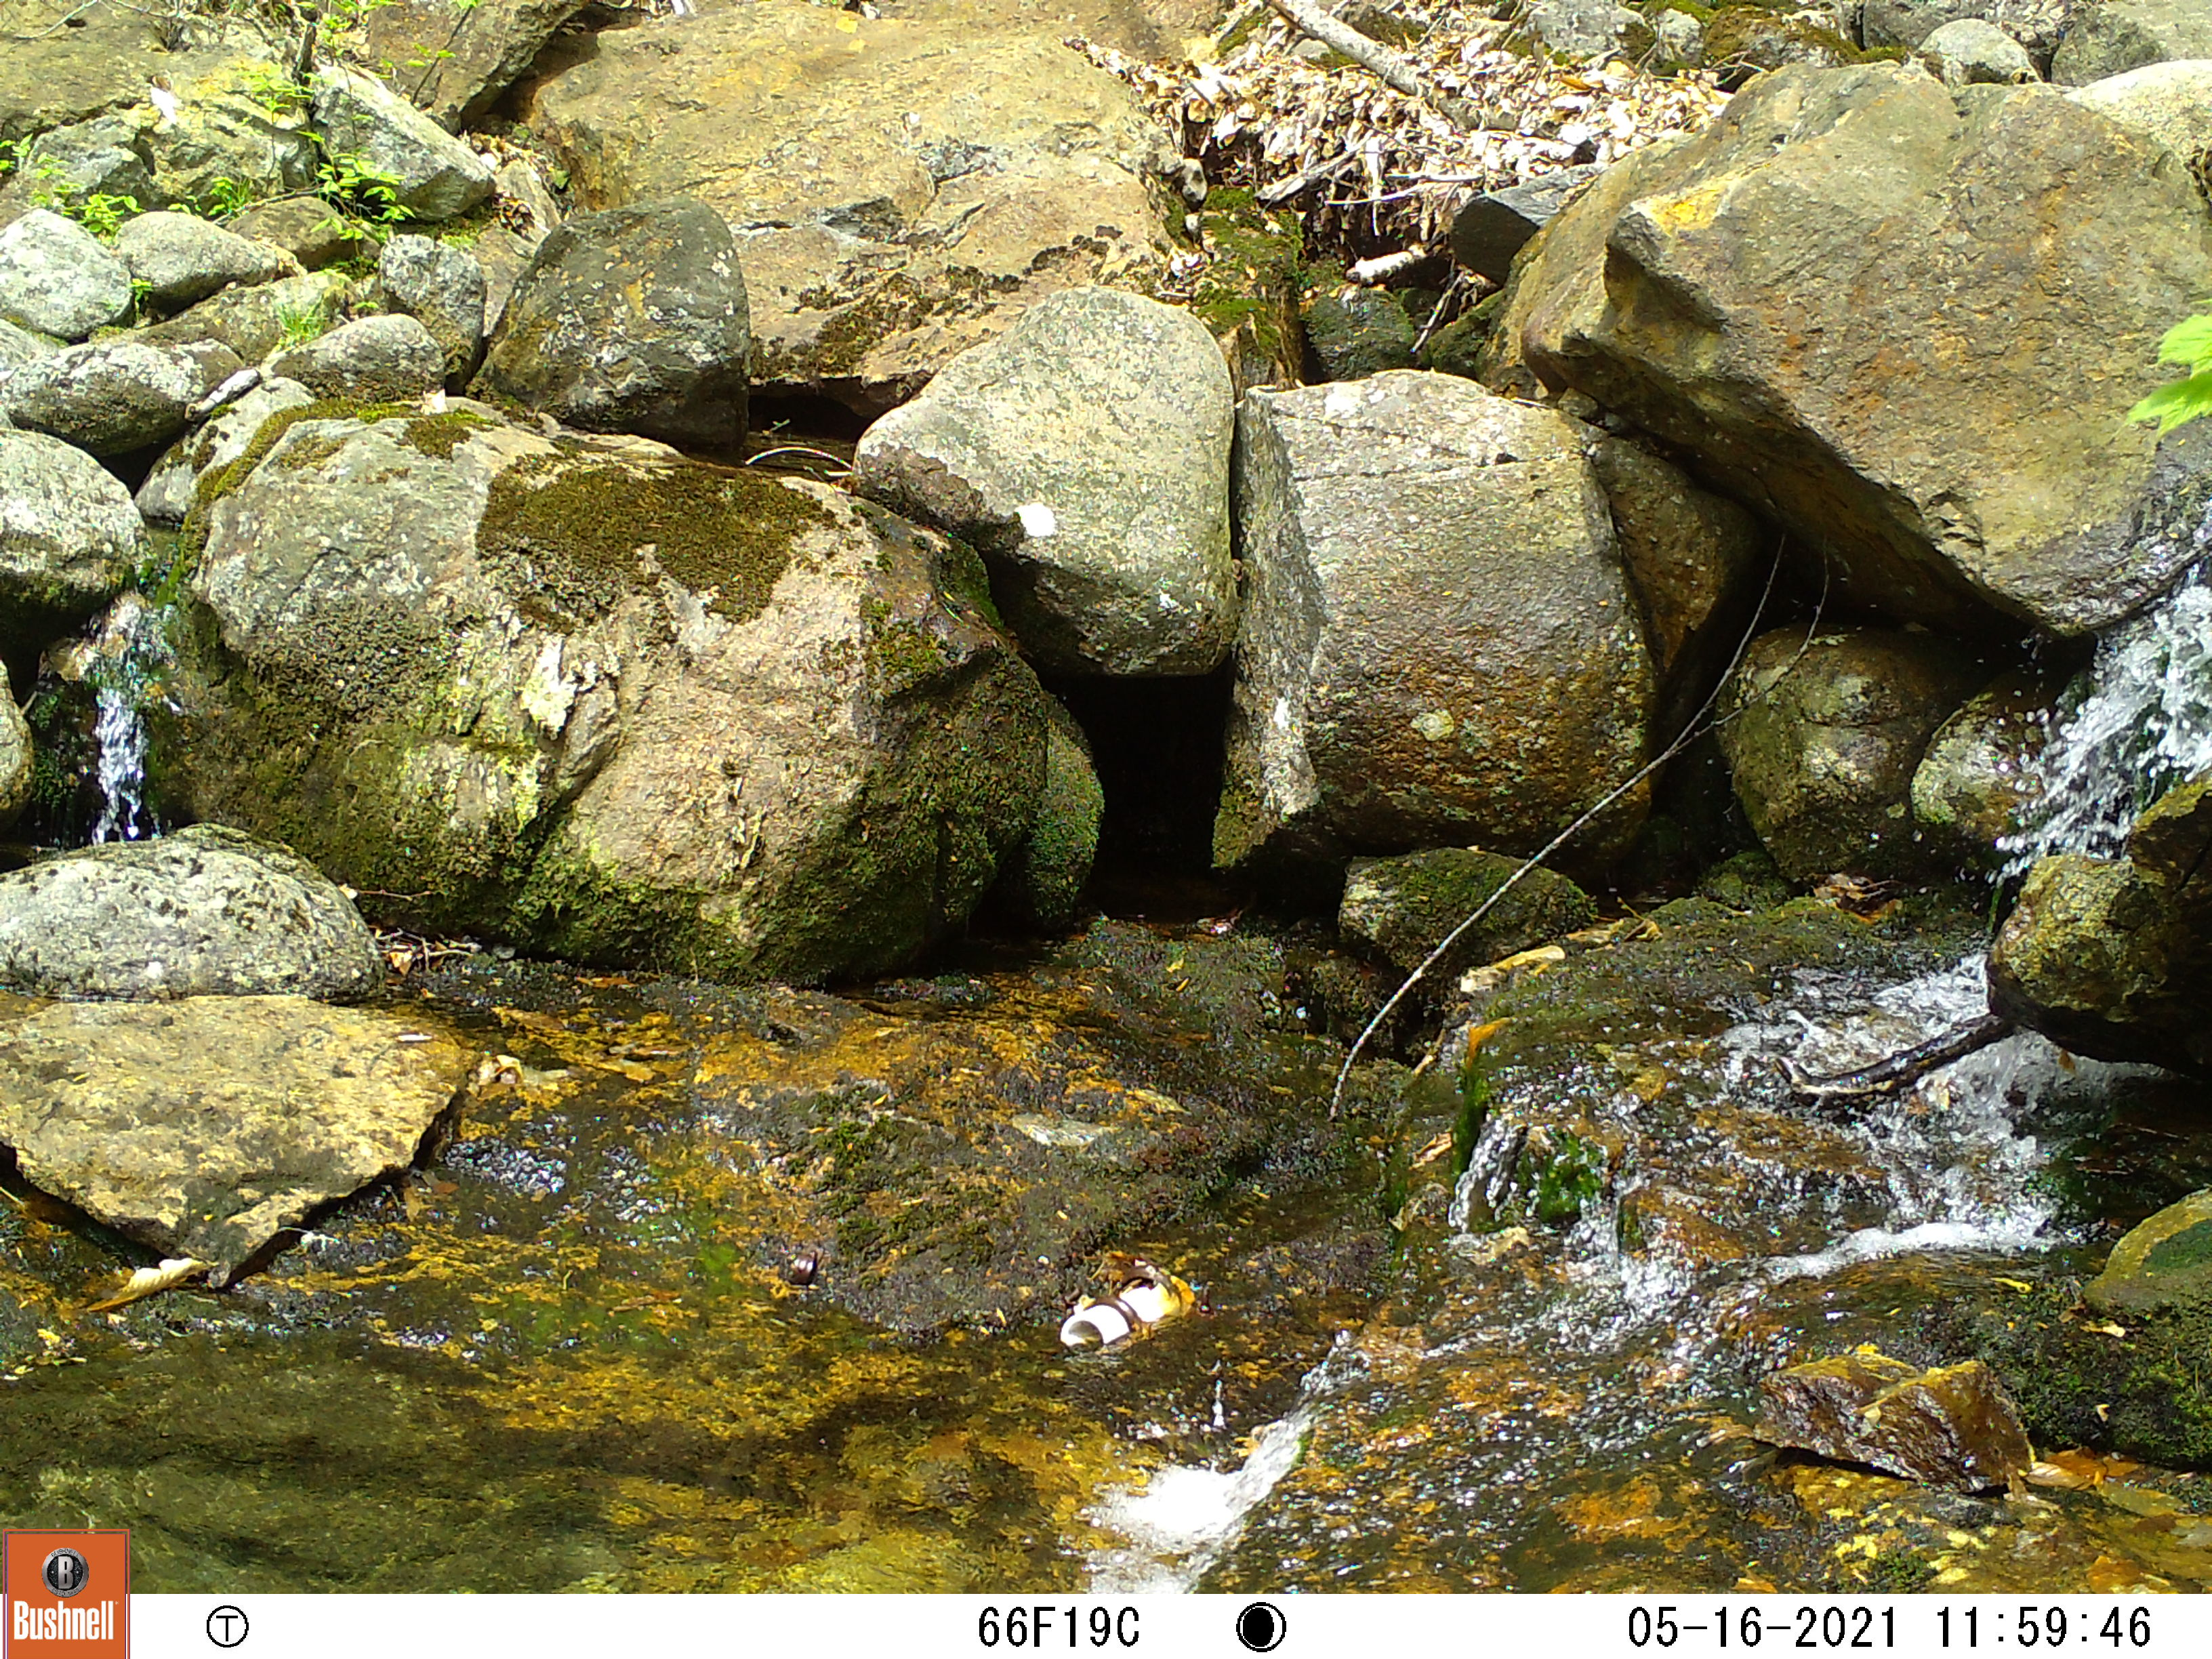

In [40]:
# View images not processed
from os.path import exists
from IPython.display import Image
path = "/content/drive/MyDrive/2_Camera Trap photos/Stream Photos/Newly_uploaded_data/W3 GC Channel 5-10-21 thru 10-24-21/05160015.JPG"
file_exists = exists(path)
print(file_exists)
Image(path)